# Análisis Exploratorio de las Etiquetas

### Importar librerías



In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nibabel as nib

In [96]:
plt.style.use("seaborn-v0_8-darkgrid")

### Limpiar el data set
(Eliminar registros que no son del pecho)

In [97]:
df1 = pd.read_csv("../datos/labels/train_predicted_labels.csv")   

with open("../datos/labels/no_chest_train.txt", "r") as f:
    rutas_largas = f.read().splitlines()
nombres_largos = [ruta.split("/")[-1] for ruta in rutas_largas]
df = df1[~df1.iloc[:,0].isin(nombres_largos)].copy()

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46397 entries, 0 to 47148
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   VolumeName                          46397 non-null  object
 1   Medical material                    46397 non-null  int64 
 2   Arterial wall calcification         46397 non-null  int64 
 3   Cardiomegaly                        46397 non-null  int64 
 4   Pericardial effusion                46397 non-null  int64 
 5   Coronary artery wall calcification  46397 non-null  int64 
 6   Hiatal hernia                       46397 non-null  int64 
 7   Lymphadenopathy                     46397 non-null  int64 
 8   Emphysema                           46397 non-null  int64 
 9   Atelectasis                         46397 non-null  int64 
 10  Lung nodule                         46397 non-null  int64 
 11  Lung opacity                        46397 non-null  int64 


In [99]:
df.head()

,VolumeName,Medical material,Arterial wall calcification,Cardiomegaly,Pericardial effusion,Coronary artery wall calcification,Hiatal hernia,Lymphadenopathy,Emphysema,Atelectasis,Lung nodule,Lung opacity,Pulmonary fibrotic sequela,Pleural effusion,Mosaic attenuation pattern,Peribronchial thickening,Consolidation,Bronchiectasis,Interlobular septal thickening
0,train_1_a_1.nii.gz,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
1,train_1_a_2.nii.gz,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
2,train_2_a_1.nii.gz,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
3,train_2_a_2.nii.gz,0,1,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0
4,train_3_a_1.nii.gz,0,1,1,0,1,0,1,0,0,1,1,1,0,0,1,0,1,0


In [100]:
disease_cols = df.columns[2:] #1 si medical material es enfermedad y 2 si no
disease_counts = df[disease_cols].sum().sort_values(ascending=False)
disease_counts


Lung nodule                           21096
Lung opacity                          17147
Arterial wall calcification           13016
Pulmonary fibrotic sequela            12411
Atelectasis                           11968
Lymphadenopathy                       11939
Coronary artery wall calcification    11663
Emphysema                              8996
Consolidation                          8223
Hiatal hernia                          6618
Pleural effusion                       5593
Cardiomegaly                           5025
Peribronchial thickening               4911
Bronchiectasis                         4691
Interlobular septal thickening         3688
Mosaic attenuation pattern             3487
Pericardial effusion                   3332
dtype: int64

In [101]:
total_registros = disease_counts.sum()
print(f"Total de registros: {total_registros:,}")


Total de registros: 153,804


# Gráficas

### Barras

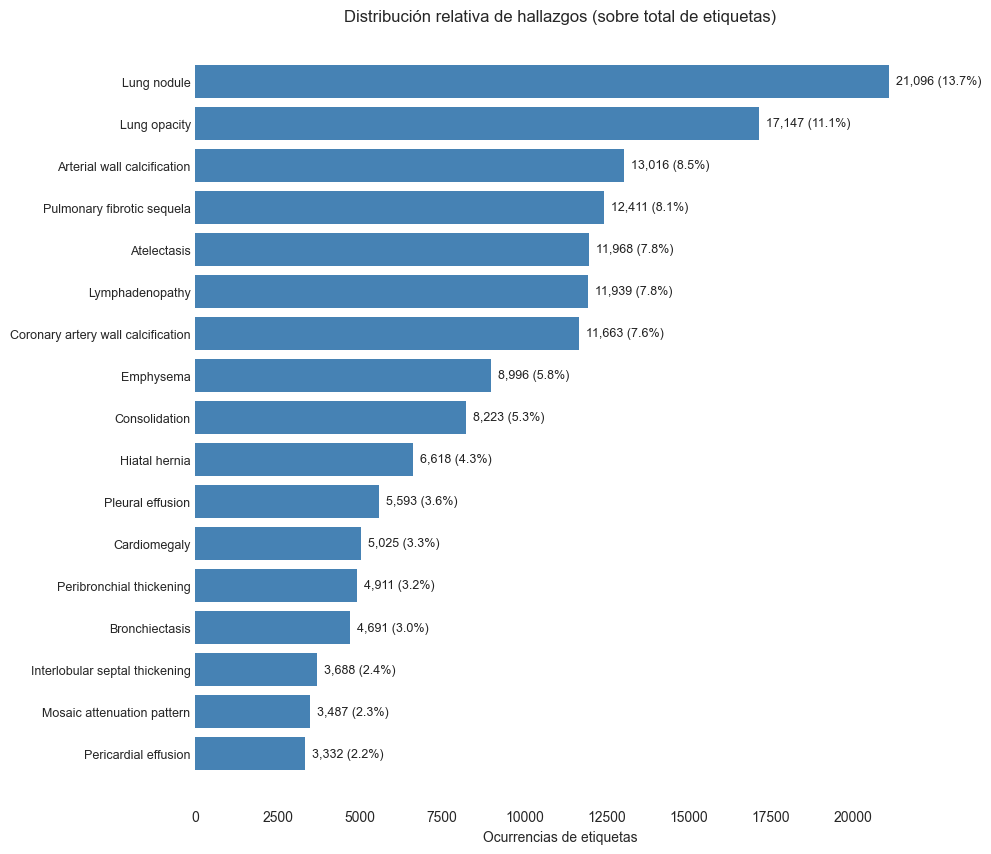

In [102]:
counts = disease_counts.sort_values(ascending=True)
total_hallazgos = counts.sum()
disease_percentages = counts / total_hallazgos * 100

plt.figure(figsize=(10, 0.45*len(counts)+1), facecolor="white")
ax = plt.gca()
ax.set_facecolor("white")

ax.barh(range(len(counts)), counts.values, color="steelblue")

m = counts.max()
for i, (c, p) in enumerate(zip(counts.values, disease_percentages.values)):
    ax.text(c + m*0.01, i, f"{c:,} ({p:.1f}%)", va='center', fontsize=9, color="#222")

ax.set_yticks(range(len(counts)))
ax.set_yticklabels(counts.index, fontsize=9)
ax.set_xlabel("Ocurrencias de etiquetas")
ax.set_title("Distribución relativa de hallazgos (sobre total de etiquetas)")

for spine in ("top","right"):
    ax.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()

### Nota
La gráfica muestra la composición relativa de todas las etiquetas positivas del conjunto: cada barra indica cuántas veces se registró un hallazgo y el porcentaje entre paréntesis corresponde a su proporción sobre el total de etiquetas (no es la prevalencia de pacientes, sino la fracción de todas las anotaciones positivas).

### Heat map

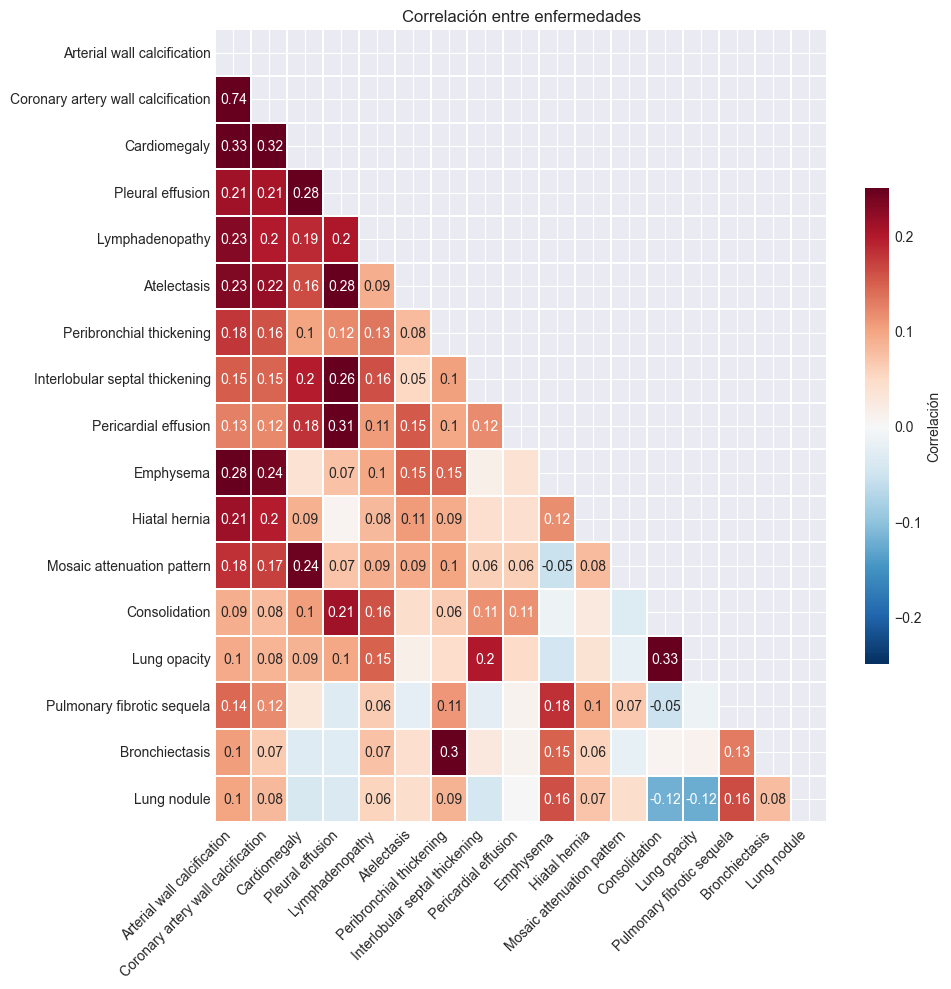

In [103]:
corr = df[disease_cols].corr()
vals, vecs = np.linalg.eigh(corr)
pc1 = vecs[:, vals.argmax()]
order = np.argsort(pc1)
corr_o = corr.iloc[order, order]

mask = np.triu(np.ones_like(corr_o, dtype=bool))

ann = corr_o.round(2).astype(str)
ann[np.abs(corr_o.values) < 0.05] = ""

plt.figure(figsize=(10,10))
sns.heatmap(
    corr_o,
    mask=mask,
    cmap="RdBu_r",
    center=0,
    vmin=-0.25, vmax=0.25,
    linewidths=.3,
    annot=ann,
    fmt="",
    cbar_kws={"shrink":0.6, "label":"Correlación"}
)
plt.title("Correlación entre enfermedades")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Nota

Este mapa muestra qué tan seguido aparecen juntas dos condiciones en los mismos estudios. Cada cuadradito compara un par:

Rojo: las dos suelen salir juntas más de lo esperado.
Azul: casi no coinciden (aparecen separadas).
Blanco o muy claro: no hay relación clara.
La escala va de -0.25 a +0.25 (valores fuera de ese rango se “recortan” para que los colores se distingan mejor). No significa porcentaje, solo indica fuerza y dirección de la relación. No implica causa; solo refleja coincidencia en este conjunto de datos

# **Afecciones torácicas:**

## 🫀 **Cardiovasculares**

### **Arterial wall calcification** (Calcificación de la pared arterial)

**¿Qué es?** Depósitos de calcio en la pared arterial (frecuente en aorta, coronarias y arterias periféricas).

**Causas:** Aterosclerosis asociada a envejecimiento y factores de riesgo: diabetes mellitus, enfermedad renal crónica, hipertensión, dislipidemia, tabaquismo e inflamación crónica.

**Significado:** Indicador de aterosclerosis, rigidez arterial y degeneración vascular crónica. 

**En CT:** Focos o líneas hiperdensas adheridas a la pared (visibles sin contraste). 

**Relevancia:** Marcador de riesgo cardiovascular y posible dificultad técnica en procedimientos.  

In [104]:
cond = "Arterial wall calcification"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Arterial wall calcification: 13,016 registros (8.46%).


### **Coronary artery wall calcification** (Calcificación de la pared arterial coronaria)

**¿Qué es?** Depósitos de calcio en la pared de las arterias coronarias.

**Causas:** Aterosclerosis relacionada con envejecimiento y factores de riesgo cardiovascular: diabetes mellitus, enfermedad renal crónica (alteración calcio-fosfato), hipertensión, dislipidemia, tabaquismo e inflamación crónica.

**Significado:** Indicador de aterosclerosis coronaria, rigidez arterial y carga aterosclerótica total.

**En CT:** Se visualiza como focos o líneas hiperdensas en la pared coronaria (sin contraste). Se cuantifica con el Agatston score.

**Relevancia:** Marcador de riesgo cardiovascular mayor, predictor de eventos coronarios (infarto de miocardio), y útil en estratificación de riesgo para prevención.

In [105]:
cond = "Coronary artery wall calcification"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Coronary artery wall calcification: 11,663 registros (7.58%).


### **Cardiomegaly** (Cardiomegalia)

**¿Qué es?** Aumento del tamaño global del corazón o de sus cavidades, visible en estudios de imagen.

**Causas:** Hipertensión arterial crónica, cardiopatía isquémica, miocardiopatías (dilatada, hipertrófica, restrictiva), valvulopatías (estenosis o insuficiencia aórtica/mitral), enfermedad pericárdica (derrame), anemia crónica, alteraciones tiroideas, alcoholismo.

**Significado:** Indica sobrecarga de presión o volumen, remodelado cardíaco y riesgo de insuficiencia cardíaca.

**En CT:** Corazón de tamaño aumentado, con diámetros de cavidades dilatados o masa miocárdica incrementada. En Rx de tórax: índice cardiotorácico > 0.5.

**Relevancia:** Marcador de insuficiencia cardíaca, riesgo de arritmias y predictor de mal pronóstico cardiovascular.

In [106]:
cond = "Cardiomegaly"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Cardiomegaly: 5,025 registros (3.27%).


### **Pericardial effusion** (Derrame pericárdico)

**¿Qué es?** Acumulación anormal de líquido en el espacio pericárdico.

**Causas:** Infecciones (virus, bacterias, tuberculosis), neoplasias, insuficiencia cardíaca, insuficiencia renal (uremia), enfermedades autoinmunes (lupus, artritis reumatoide), traumatismos, postquirúrgico, hipotiroidismo, idiopático.

**Significado:** Indica inflamación, lesión o compromiso sistémico; puede evolucionar a taponamiento cardíaco si el volumen es significativo o de rápida acumulación.

**En CT:** Engrosamiento aparente del espacio pericárdico con líquido hipodenso que rodea al corazón; en ecocardiografía se confirma y cuantifica.

**Relevancia:** Puede comprometer el llenado cardíaco (taponamiento), generar inestabilidad hemodinámica y requerir drenaje (pericardiocentesis).

In [107]:
cond = "Pericardial effusion"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Pericardial effusion: 3,332 registros (2.17%).


## 🫁 **Pulmonares**


### **Emphysema** (Efisema pulmonar)

**¿Qué es?** Enfermedad pulmonar caracterizada por la destrucción irreversible de las paredes alveolares y dilatación anormal de los espacios aéreos distales.

**Causas:** Principalmente tabaquismo; también déficit de alfa-1 antitripsina, exposición a biomasa, contaminación ambiental y envejecimiento pulmonar acelerado.

**Significado:** Indica daño crónico de la arquitectura pulmonar con pérdida de la elasticidad, atrapamiento aéreo y alteración del intercambio gaseoso.

**En CT:** Áreas de baja atenuación sin paredes visibles (“black holes”), hiperinflación, disminución del calibre vascular y bullas enfisematosas.

**Relevancia:** Componente central de la EPOC, causa disnea progresiva, deterioro funcional y aumento de la morbimortalidad respiratoria y cardiovascular.

In [108]:
cond = "Emphysema"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Emphysema: 8,996 registros (5.85%).



### **Atelectasis** (Atelectasia)

**¿Qué es?** Colapso parcial o completo del parénquima pulmonar por pérdida de aire en los alvéolos.

**Causas:** Obstrucción bronquial (tapones de moco, cuerpos extraños, tumores), compresión extrínseca (derrame pleural, neumotórax, masas), hipoventilación postoperatoria, fibrosis pulmonar.

**Significado:** Indica pérdida de volumen pulmonar y compromiso en la ventilación, puede ser reversible si se trata la causa.

**En CT:** Áreas de aumento de densidad con retracción de estructuras adyacentes (desplazamiento de cisuras, bronquios, vasos), reducción del volumen pulmonar afectado; en Rx se ve opacidad con signos de pérdida de volumen.

**Relevancia:** Puede causar hipoxemia, predisponer a infecciones y complicar procedimientos; hallazgo común en pacientes hospitalizados y postquirúrgicos.

In [109]:
cond = "Atelectasis"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Atelectasis: 11,968 registros (7.78%).


### **Lung nodule** (Nódulo pulmonar)

**¿Qué es?** Lesión redondeada u ovalada en el parénquima pulmonar, de ≤3 cm de diámetro, rodeada por pulmón normal.

**Causas:** Infecciones (tuberculosis, histoplasmosis, otras micosis), lesiones benignas (hamartomas, malformaciones vasculares), procesos inflamatorios (sarcoidosis, neumonía organizada) y neoplasias (carcinoma broncogénico, metástasis, linfoma).

**Significado:** Puede ser hallazgo incidental o manifestación de enfermedad infecciosa, inflamatoria o neoplásica; requiere valoración de riesgo.

**En CT:** Nódulo sólido, sub-sólido o en vidrio esmerilado; se evalúan bordes, densidad, calcificación, tamaño y crecimiento en controles seriados.

**Relevancia:** La principal preocupación es descartar malignidad; su detección y seguimiento son clave en la prevención y diagnóstico temprano de cáncer de pulmón.



In [110]:
cond = "Lung nodule"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Lung nodule: 21,096 registros (13.72%).


### **Lung opacity** (Opacidad pulmonar)

**¿Qué es?** Área de aumento en la atenuación del parénquima pulmonar que reduce la visualización de los vasos y estructuras adyacentes.

**Causas:** Procesos infecciosos (neumonía bacteriana, viral, micótica, tuberculosis), inflamatorios (neumonitis, sarcoidosis), hemorrágicos (hemorragia alveolar), neoplásicos (adenocarcinoma, linfoma, metástasis) y ocupación alveolar por líquido (edema pulmonar, aspiración).

**Significado:** Refleja pérdida de la aireación pulmonar y puede ser transitoria o persistente según la etiología.

**En CT:** Se observa como consolidación, vidrio esmerilado o patrón mixto; se evalúa extensión, distribución y asociación con otras lesiones.

**Relevancia:** Requiere correlación clínica y seguimiento, ya que abarca desde infecciones benignas hasta neoplasias malignas.

In [111]:
cond = "Lung opacity"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Lung opacity: 17,147 registros (11.15%).


### **Pulmonary fibrotic sequela** (Secuela fibrótica pulmonar)

**¿Qué es?** Cambios fibróticos residuales en el parénquima pulmonar tras procesos inflamatorios, infecciosos o lesivos previos, caracterizados por cicatrización y distorsión de la arquitectura pulmonar.

**Causas:** Secuelas de neumonías graves (incluyendo tuberculosis), infecciones micóticas, exposición a polvos inorgánicos (neumoconiosis), daño pulmonar por radiación, enfermedades autoinmunes (artritis reumatoide, esclerosis sistémica) y como resultado de síndrome de distrés respiratorio agudo o COVID-19.

**Significado:** Indican daño pulmonar crónico e irreversible con pérdida de la elasticidad y disminución de la capacidad respiratoria.

**En CT:** Se observan reticulación, bronquiectasias por tracción, engrosamiento septal y patrón en panal de abeja en áreas avanzadas.

**Relevancia:** Requieren diferenciación de fibrosis activa vs. secuela estable; tienen implicación pronóstica y funcional en la enfermedad pulmonar.

In [112]:
cond = "Pulmonary fibrotic sequela"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Pulmonary fibrotic sequela: 12,411 registros (8.07%).


### **Mosaic attenuation pattern** (Patrón de atenuacion en mosaico)

**¿Qué es?** Alteración heterogénea de la atenuación pulmonar en la tomografía, que se manifiesta como regiones adyacentes de parénquima con diferente densidad.

**Causas:** Puede deberse a tres grandes mecanismos: enfermedades de la vía aérea (bronquiolitis, asma, bronquiolitis obliterante), alteraciones vasculares (hipertensión pulmonar crónica, tromboembolismo pulmonar crónico) o enfermedades parenquimatosas (neumonías intersticiales, neumonía en organización).

**Significado:** Refleja un proceso subyacente que produce distribución desigual del flujo de aire o sangre, o infiltración del parénquima.

**En CT:** Se observan áreas hipodensas (hipoatenuadas, atrapamiento aéreo) junto a zonas hiperdensas (hiperatenuadas, perfusión aumentada o infiltración). El uso de expiración en la TC ayuda a identificar atrapamiento aéreo.

**Relevancia:** Es un hallazgo inespecífico que requiere correlación clínica y funcional para distinguir entre causas de origen vascular, bronquiolar o parenquimatoso.

In [113]:
cond = "Mosaic attenuation pattern"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Mosaic attenuation pattern: 3,487 registros (2.27%).


### **Peribronchial thickening** (Engrosamiento peribronquial)

**¿Qué es?** Engrosamiento de las paredes bronquiales y del tejido que rodea a los bronquios, visible en estudios de imagen.

**Causas:** Asociado principalmente a inflamación e infección (bronquitis aguda, bronquitis crónica, bronquiolitis), asma, fibrosis quística, insuficiencia cardíaca congestiva y enfermedades intersticiales.

**Significado:** Indica afectación inflamatoria, infecciosa o congestiva de la vía aérea, y puede ser signo de enfermedad pulmonar obstructiva crónica (EPOC) o sobrecarga hídrica.

**En CT:** Se observa como un engrosamiento de las paredes bronquiales, con apariencia de “signo del anillo” (bronquio engrosado en corte transversal) o “signo de las vías aéreas paralelas” en cortes longitudinales.

**Relevancia:** Es un hallazgo inespecífico pero útil para sugerir procesos inflamatorios, infecciosos o congestivos, ayudando en la diferenciación entre causas pulmonares y cardíacas.

In [114]:
cond = "Peribronchial thickening"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Peribronchial thickening: 4,911 registros (3.19%).


### **Consolidation** (Cosolidación pulmobar)

**¿Qué es?** Sustitución del aire alveolar por líquido, células inflamatorias, sangre, proteínas o tejido, lo que provoca aumento de la densidad pulmonar.

**Causas:** La más común es la neumonía, pero también puede deberse a edema pulmonar, hemorragia alveolar, aspiración, enfermedades intersticiales, neoplasias y síndrome de distrés respiratorio agudo (SDRA).

**Significado:** Indica ocupación de los espacios alveolares y alteración del intercambio gaseoso; suele reflejar un proceso infeccioso, inflamatorio o hemorrágico.

**En CT:** Se observa como áreas de aumento de densidad que borran la visualización de vasos y paredes bronquiales, aunque pueden verse broncogramas aéreos (bronquios llenos de aire en medio de la consolidación).

**Relevancia:** Hallazgo clave en el diagnóstico diferencial de enfermedades agudas y crónicas; orienta principalmente hacia infección (neumonía), pero también puede señalar otras patologías graves como hemorragia o edema.

In [115]:
cond = "Consolidation"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Consolidation: 8,223 registros (5.35%).


### **Bronchiectasis** (Bronquiectasia)

**¿Qué es?** Dilatación anormal e irreversible de los bronquios debida a destrucción de su pared.

**Causas:** Infecciones respiratorias recurrentes, fibrosis quística, bronquitis crónica, tuberculosis, inmunodeficiencias, obstrucción bronquial, enfermedades autoinmunes y exposición prolongada a irritantes.

**Significado:** Refleja daño estructural pulmonar crónico con predisposición a infecciones de repetición, tos crónica y producción excesiva de esputo.

**En CT:** Se observan bronquios dilatados con luz mayor que el vaso acompañante (“signo del anillo de sello”), falta de estrechamiento progresivo de los bronquios y engrosamiento de sus paredes.

**Relevancia:** Hallazgo de enfermedad pulmonar crónica con implicaciones en calidad de vida, riesgo de exacerbaciones infecciosas y progresión a insuficiencia respiratoria.

In [116]:
cond = "Bronchiectasis"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Bronchiectasis: 4,691 registros (3.05%).


### **Interlobular septal thickening** (Engrosamiento septal interlobulillar)

**¿Qué es?** Engrosamiento de los tabiques interlobulillares del pulmón, visibles en TC como líneas que delimitan los lóbulos secundarios.

**Causas:** Edema pulmonar (insuficiencia cardíaca), enfermedades intersticiales (fibrosis pulmonar, neumonía intersticial), linfangitis carcinomatosa, infecciones, hemorragia alveolar y algunas enfermedades ocupacionales.

**Significado:** Indica afectación del intersticio pulmonar, pudiendo ser transitorio (como en edema) o crónico (fibrosis, neoplasia).

**En CT:** Se visualizan líneas finas, paralelas, que delimitan los lóbulos secundarios; pueden ser lisas (edema), nodulares (linfangitis carcinomatosa) o irregulares (fibrosis).

**Relevancia:** Hallazgo clave en la evaluación de enfermedades intersticiales y en el diagnóstico diferencial de disnea y alteraciones respiratorias.

In [117]:
cond = "Interlobular septal thickening"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Interlobular septal thickening: 3,688 registros (2.40%).


## 🫁🫀 **Otros hallazgos torácicos**

### **Pleural effusion** (Derrame pleural)

**¿Qué es?** Acumulación anormal de líquido en el espacio pleural, entre la pleura visceral y la pleura parietal.

**Causas:** Insuficiencia cardíaca, infecciones (neumonía, tuberculosis, empiema), neoplasias, tromboembolismo pulmonar, enfermedades hepáticas (cirrosis con hidrotórax), renales (síndrome nefrótico), pancreatitis y causas postquirúrgicas o traumáticas.

**Significado:** Indica alteración del equilibrio entre producción y reabsorción del líquido pleural; puede reflejar patología local o sistémica.

**En CT:** Se observa como colección hipodensa que ocupa el espacio pleural, desplazando el pulmón; puede ser libre, loculado o asociado a engrosamiento pleural.

**Relevancia:** Hallazgo frecuente y clínicamente importante; su caracterización (trasudado vs. exudado) y volumen ayudan en el diagnóstico diferencial y en la toma de decisiones terapéuticas (p. ej., drenaje).

In [118]:
cond = "Pleural effusion"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Pleural effusion: 5,593 registros (3.64%).


### **Lymphadenopathy** (Linfadenopatia)

**¿Qué es?** Aumento de tamaño o alteración en la morfología de los ganglios linfáticos intratorácicos.

**Causas:** Procesos infecciosos (tuberculosis, neumonía, infecciones virales), inflamatorios (sarcoidosis, enfermedades autoinmunes), neoplásicos (linfoma, metástasis de cáncer pulmonar u otros tumores), y reacciones postinflamatorias.

**Significado:** Indica compromiso del sistema linfático torácico, pudiendo corresponder a infección activa, inflamación crónica o neoplasia.

**En CT:** Se visualizan ganglios aumentados de tamaño (>10 mm en eje corto), hiperdensos o con realce tras contraste; pueden estar calcificados, necróticos o con distribución mediastinal e hiliar.

**Relevancia:** Hallazgo importante para diagnóstico diferencial de patologías torácicas; ayuda en estadificación oncológica y orientación terapéutica (ej. necesidad de biopsia o seguimiento)..

In [119]:
cond = "Lymphadenopathy"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Lymphadenopathy: 11,939 registros (7.76%).


### **Hiatal hernia** (Hernia hiatal)

**¿Qué es?** Protrusión de parte del estómago a través del hiato esofágico del diafragma hacia el tórax.

**Causas:** Debilidad del diafragma, aumento de la presión intraabdominal (obesidad, tos crónica, embarazo), envejecimiento, traumatismos o antecedentes quirúrgicos.

**Significado:** Alteración anatómica que favorece reflujo gastroesofágico, esofagitis crónica y complicaciones digestivas o respiratorias.

**En CT:** Se observa contenido gástrico (aire, nivel hidroaéreo o pared gástrica) en el mediastino posterior, por encima del diafragma. Puede distinguirse hernia por deslizamiento (más común) o paraesofágica.

**Relevancia:** Hallazgo frecuente, con importancia clínica variable; en casos grandes puede causar síntomas respiratorios, anemia por sangrado crónico o complicaciones como vólvulo gástrico.


In [120]:
cond = "Hiatal hernia"
print(f"{cond}: {disease_counts[cond]:,} registros ({disease_percentages[cond]:.2f}%).")

Hiatal hernia: 6,618 registros (4.30%).


# Número de enfermedades por registro 

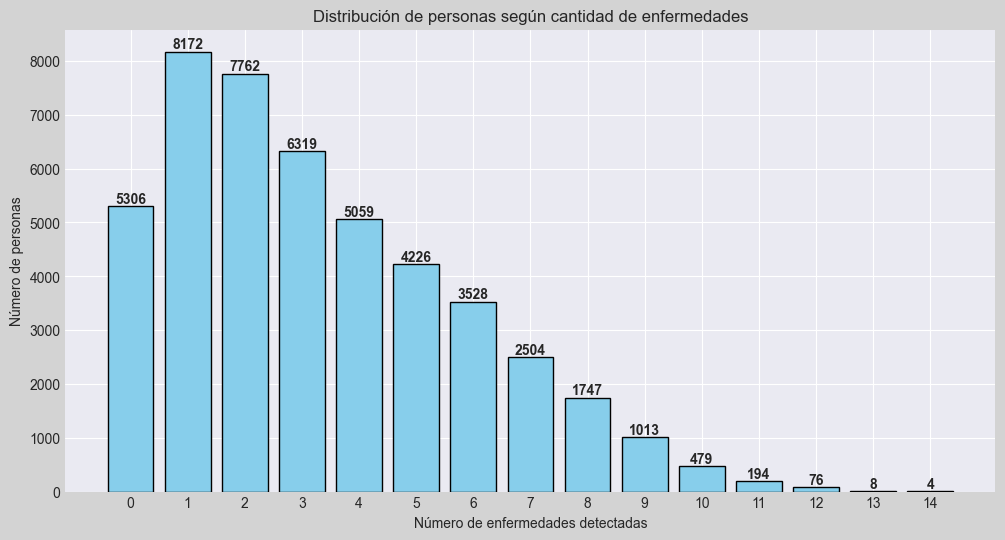

In [121]:
df.loc[:, "n_enfermedades"] = df[disease_cols].sum(axis=1)

rango = range(0, int(df["n_enfermedades"].max()) + 1)
conteo = df["n_enfermedades"].value_counts().reindex(rango, fill_value=0)

plt.figure(figsize=(12,6), facecolor="lightgrey")
bars = plt.bar(conteo.index, conteo.values, color="skyblue", edgecolor="black")

plt.xlabel("Número de enfermedades detectadas")
plt.ylabel("Número de personas")
plt.title("Distribución de personas según cantidad de enfermedades")
plt.xticks(conteo.index)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height + 1,
        f"{int(height)}",
        ha="center", va="bottom", fontsize=10, fontweight="bold"
    )

plt.show()

### Notar que no existen registros con mas de 14 patoligías a la vez